# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        try:
            keys = tuple(obj.keys())
            if keys in __namedtuples:
                nt = __namedtuples[keys]
            else:
                nt = namedtuple(type_name, keys)
                __namedtuples[keys] = nt
            return nt(*(to_namedtuple(v, "type_" + k) for k, v in obj.items()))
        except ValueError:
            return {k: to_namedtuple(v, f"{type_name}_{i}") for i, (k, v) in enumerate(obj.items())}
    if isinstance(obj, list):
        item_type_name = "element_" + type_name 
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = "element_" + type_name 
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = "element_" + type_name 
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
import torch

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan, torch])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/cifar10_coreset_pig")

In [ ]:
get_any(results).config

_typeConfig(seed=8961, experiment_data_config=_typeExperimentDataConfig(id_dataset_name='CIFAR-10', id_repetitions=1, initial_training_set_size=0, validation_set_size=0, validation_split_random_state=0, evaluation_set_size=0, add_dataset_noise=False, ood_dataset_config=None), acquisition_size=5, max_training_set=100, max_training_epochs=300, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, device='cuda', acquisition_function='batchbald_redux.acquisition_functions.CoreSetPIGBALD', train_eval_model='batchbald_redux.train_eval_model.TrainExplicitEvalModel', model_trainer_factory='batchbald_redux.resnet_models.Cifar10ModelTrainer', ensemble_size=5, temperature=0.0, epig_bootstrap_type='BootstrapType.NO_BOOTSTRAP', epig_bootstrap_factor=1.0, epig_dtype=torch.float64, disable_training_augmentations=True, cache_explicit_eval_model=True)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,12,1634475454
1,14,1634511678
2,1,1634389407
3,6,1634389472
4,4,1634389407
5,3,1634389448
6,10,1634473580
7,8,1634389467
8,2,1634389431
9,0,1634389456


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

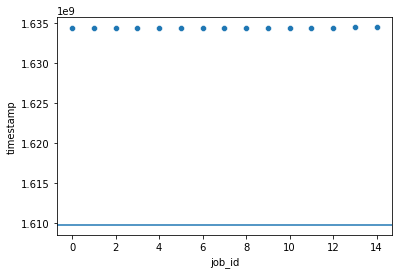

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd.axhline(y=790000 + 1.609e9)
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(15, 15)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    acquisition_size = result.config.acquisition_size
    
    acquisition_function = result.config.acquisition_function
    if acquisition_function.startswith("batchbald_redux.acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    elif acquisition_function.startswith("batchbald_redux.baseline_acquisition_functions."):
        acquisition_function=acquisition_function[len("batchbald_redux.baseline_acquisition_functions.") :]
        
    num_pool_samples = result.config.num_pool_samples
    
    seed = result.config.seed

    if acquisition_function == "random":
        acquisition_sizes = [5, 10, 20, 50]
    else:
        acquisition_sizes = [acquisition_size]
        
    if acquisition_function == "random":
        num_pool_samples = [10, 20, 50, 100]
    else:
        num_pool_samples = [num_pool_samples]
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * result.config.acquisition_size
                < 99
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * result.config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy
                nll = step.evaluation_metrics.crossentropy

                experiment_data.append(
                    dict(
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        nll=nll,
                        seed=seed,
                    )
                )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,nll,seed
0,CoreSetPIGBALD,5,100,0,0.1002,2.315949,8961
1,CoreSetPIGBALD,5,100,5,0.1259,9.903801,8961
2,CoreSetPIGBALD,5,100,10,0.1476,4.231960,8961
3,CoreSetPIGBALD,5,100,15,0.0997,5.854013,8961
4,CoreSetPIGBALD,5,100,20,0.1358,5.104224,8961
...,...,...,...,...,...,...,...
310,CoreSetPIGBALD,5,100,80,0.1785,3.135439,8957
311,CoreSetPIGBALD,5,100,85,0.1658,2.893751,8957
312,CoreSetPIGBALD,5,100,90,0.1776,2.828178,8957
313,CoreSetPIGBALD,5,100,95,0.1678,3.097540,8957


In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby("acquisition_size")["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 BALD                    5
                  CoreSetPIG              5
                  CoreSetPIGBALD          5
Name: num_trials, dtype: int64


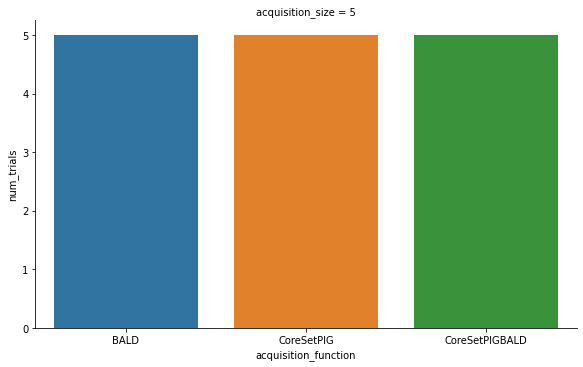

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

In [ ]:
dff = df.copy()

In [ ]:
dff.training_set_size[dff.acquisition_function!="BALD"] = dff[dff.acquisition_function!="BALD"].training_set_size / 4

<ipython-input-37-3b929c9f6516>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.training_set_size[dff.acquisition_function!="BALD"] = dff[dff.acquisition_function!="BALD"].training_set_size / 4


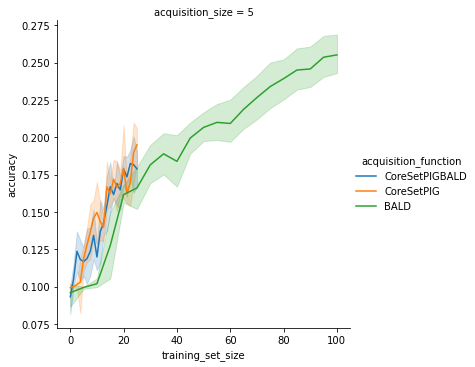

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=dff, #[df.acquisition_function != "CoreSetPIGBALD"],
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
#df.to_pickle("./plots_data/epig_vs_evalbald_bald.pkl")

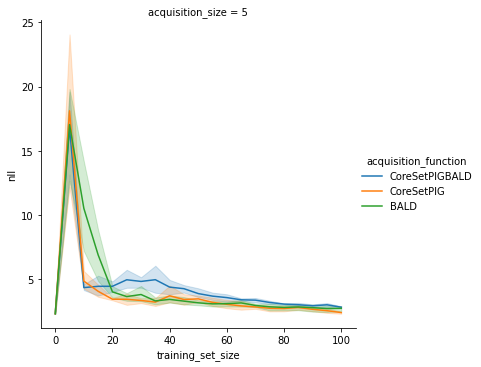

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="nll",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,nll,seed,max_accuracy
0,CoreSetPIGBALD,1,100,20,0.6186,1.623821,8959,0.6186
1,CoreSetPIGBALD,1,100,21,0.6637,1.195012,8959,0.6637
5,CoreSetPIGBALD,1,100,25,0.7008,1.036488,8959,0.7008
6,CoreSetPIGBALD,1,100,26,0.7200,0.989536,8959,0.7200
11,CoreSetPIGBALD,1,100,31,0.8027,0.668213,8959,0.8027
...,...,...,...,...,...,...,...,...
1489,CoreSetPIG,1,100,95,0.9258,0.330932,8946,0.9258
1496,CoreSetPIG,1,100,102,0.9293,0.415632,8946,0.9293
1506,CoreSetPIG,1,100,112,0.9371,0.340744,8946,0.9371
1512,CoreSetPIG,1,100,118,0.9380,0.398636,8946,0.9380


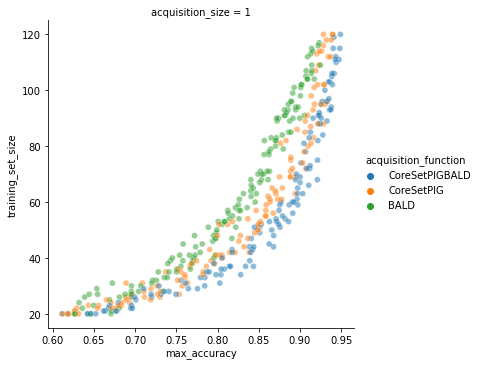

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed", "acquisition_size", "acquisition_function"]).first()
df2

,,,num_pool_samples,training_set_size,accuracy,nll,max_accuracy
seed,acquisition_size,acquisition_function,,,,,
8945,1,BALD,100,98,0.9006,0.336600,0.9006
8946,1,CoreSetPIG,100,74,0.9033,0.400606,0.9033
8947,1,CoreSetPIGBALD,100,72,0.9083,0.346604,0.9083
8949,1,BALD,100,101,0.9010,0.325310,0.9010
8950,1,CoreSetPIG,100,85,0.9062,0.584206,0.9062
8951,1,CoreSetPIGBALD,100,68,0.9211,0.321199,0.9211
8953,1,BALD,100,91,0.9055,0.341838,0.9055
8954,1,CoreSetPIG,100,89,0.9064,0.379929,0.9064
8955,1,CoreSetPIGBALD,100,63,0.9033,0.334889,0.9033


In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                       0.25   0.50   0.75
acquisition_size acquisition_function                    
1                BALD                  98.0  101.0  102.0
                 CoreSetPIG            74.0   78.0   85.0
                 CoreSetPIGBALD        67.0   68.0   69.0
